# 03. RAG Evaluation (LLM-as-a-Judge)

In this notebook, we will evaluate the quality of our RAG pipeline using the **LLM-as-a-Judge** paradigm.
We will use the Gemma 2 model itself to evaluate its own outputs (or outputs from the pipeline) based on two key metrics:

1.  **Faithfulness**: Is the answer derived *solely* from the retrieved context?
2.  **Answer Relevance**: Does the answer directly address the user's question?

We will score these on a scale of 1-5.

In [ ]:
# ==========================================
# 1. Global Setup & Imports
# ==========================================
import os
import sys
import gc
import torch
import pandas as pd
import tqdm
import tqdm.auto
import tqdm.notebook
import tqdm.std
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import Project Modules
import src.rag
import src.visualization
import src.evaluation 
import src.generation
from src.rag import RAGPipeline
from src.visualization import set_plot_style

# Force standard text-based progress bar
tqdm.tqdm = tqdm.std.tqdm
tqdm.auto.tqdm = tqdm.std.tqdm
tqdm.notebook.tqdm = tqdm.std.tqdm

# Reload modules to ensure latest logic
importlib.reload(src.rag)
importlib.reload(src.visualization)
importlib.reload(src.evaluation)
importlib.reload(src.generation)

# Set plot style
set_plot_style()

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ==========================================
# 2. Initialize RAG Pipeline
# ==========================================
# Clean up memory to avoid OOM if re-running
print("Cleaning up memory...")
try:
    del rag
except NameError:
    pass
gc.collect()
torch.cuda.empty_cache()

# Initialize Pipeline
print(f"Initializing RAG Pipeline on {device}...")
rag = RAGPipeline(device=device)
rag.load_resources()

# Verify model placement
print(f"Model device map: {rag.model.hf_device_map if hasattr(rag.model, 'hf_device_map') else rag.model.device}")

Cleaning up memory...
Initializing RAG Pipeline on cuda...
--- Loading RAG Resources on CUDA ---
Loading Knowledge Base from: c:\Users\matteucc\Desktop\Portfolio_improvement\Medical_question_answering\data\knowledge_base.parquet
Loading FAISS Index from: c:\Users\matteucc\Desktop\Portfolio_improvement\Medical_question_answering\data\faiss_index.bin
Loading Embedding Model: all-MiniLM-L6-v2
Loading LLM: google/gemma-2-2b-it


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


All resources loaded successfully.

Model device map: {'': device(type='cuda')}


# Section 1: Data Generation

We generate a synthetic test set of 50 queries based on the medical dataset. 
The generation process includes validation to ensure questions are actually answerable from the context.

In [ ]:
# ==========================================
# 3. Generate Synthetic Test Set
# ==========================================
# Configuration
FORCE_GENERATE_QUERIES = False 
queries_path = '../output/generated_test_queries.csv'

# Generate or Load Queries
eval_queries_df = src.generation.generate_synthetic_queries(
    rag, 
    num_queries=50, 
    output_path=queries_path, 
    seed=42, 
    force=FORCE_GENERATE_QUERIES
)

# Extract questions list
if isinstance(eval_queries_df, pd.DataFrame):
    eval_queries = eval_queries_df['question'].tolist()
else:
    eval_queries = eval_queries_df

# Filter out garbage queries
print(f"Initial queries loaded: {len(eval_queries)}")
original_count = len(eval_queries)

filtered_queries = [
    q for q in eval_queries 
    if q.strip().endswith('?') 
    and not q.strip().startswith('*') 
    and not q.strip().startswith('Explanation:')
    and len(q.strip()) > 15
]

eval_queries = filtered_queries
print(f"Filtered out {original_count - len(eval_queries)} garbage queries.")
print(f"Remaining queries for evaluation: {len(eval_queries)}")

# Save Cleaned Queries for Inspection
clean_queries_path = '../output/clean_test_queries.txt'
with open(clean_queries_path, 'w', encoding='utf-8') as f:
    for i, q in enumerate(eval_queries, 1):
        f.write(f"{i}. {q}\n")

print(f"Cleaned queries saved to: {clean_queries_path}")

Loading existing queries from ../output/generated_test_queries.csv...
Loaded 55 queries.
Initial queries loaded: 55
Filtered out 1 garbage queries.
Remaining queries for evaluation: 54
Cleaned queries saved to: ../output/clean_test_queries.txt
Detailed validation report saved to: ../output/generated_test_queries_detailed.txt
You can inspect this file to verify that each question is answerable from its context.


# Section 2: Execution (LLM-as-a-Judge)

We run the evaluation on two scenarios:
1.  **RAG + Abstain**: The full pipeline.
2.  **No RAG (LLM Only)**: The model answering from its internal weights.

The results are saved to `output/evaluation_results_full.csv`.

In [ ]:
# ==========================================
# 4. Run Comprehensive Evaluation
# ==========================================
# Configuration
FORCE_RUN_EVALUATION = False 
results_path = '../output/evaluation_results_full.csv'
detailed_output_path = '../output/detailed_evaluation_analysis.txt'

# Check if we should skip execution
if not FORCE_RUN_EVALUATION and os.path.exists(results_path):
    print(f"Found existing results at {results_path}. Skipping re-evaluation.")
    results_df = pd.read_csv(results_path)
else:
    # Get queries and contexts
    if isinstance(eval_queries_df, pd.DataFrame):
        queries = eval_queries_df['question'].tolist()
        contexts = eval_queries_df['source_context'].tolist()
    else:
        queries = eval_queries
        contexts = ["(Context not available)"] * len(queries)

    print(f"FULL MODE: Running on all {len(queries)} queries.")
    
    # Run evaluation
    results_df = src.evaluation.run_comprehensive_evaluation(
        rag, 
        queries, 
        contexts, 
        detailed_output_path, 
        results_path
    )

FULL MODE: Running on all 55 queries.
Starting Detailed Evaluation on 55 queries...
Detailed report will be saved to: ../output/detailed_evaluation_analysis.txt


Evaluating: 100%|██████████| 55/55 [52:58<00:00, 57.80s/it]   

Results saved to ../output/evaluation_results_full.csv


# Section 3: Quantitative Analysis

We analyze the results using:
1.  **ROUGE Scores**: Lexical overlap with ground truth context.
2.  **Faithfulness & Relevance**: LLM-judged metrics.
3.  **Abstention Rates**: How often the model refuses to answer.

Calculating ROUGE scores for 153 valid answers...

Generating ROUGE Score Plot...

ROUGE-L Stats (Answer vs. Context):
            Scenario      mean       sem  count       std
0  No RAG (LLM Only)  0.146699  0.007570     55  0.056144
1   RAG (No Abstain)  0.149540  0.016474     55  0.122172
2      RAG + Abstain  0.158770  0.018886     43  0.123845
Plot saved to: ../output\rouge_scores.png


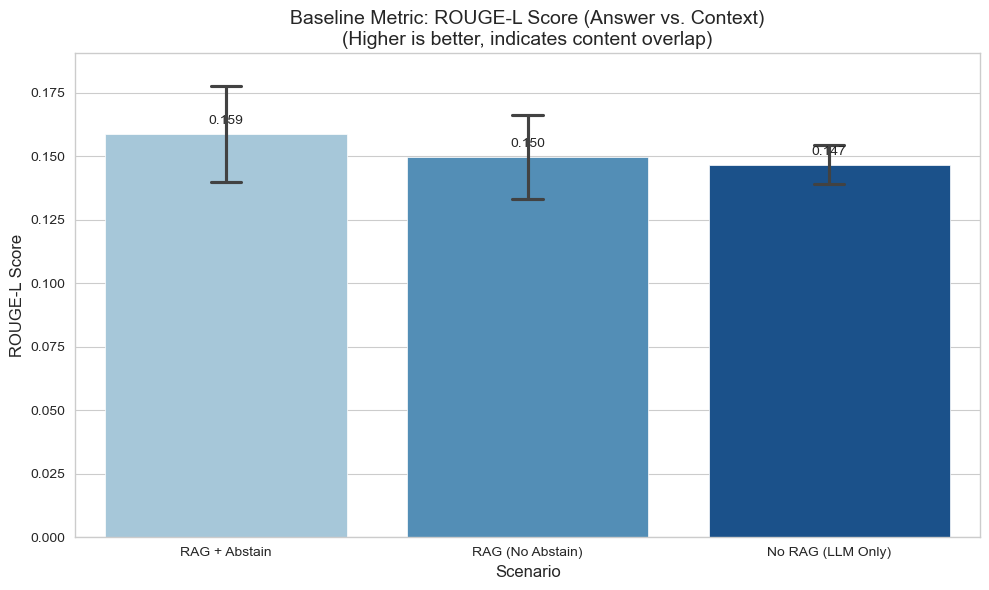

In [ ]:
# ==========================================
# 5. ROUGE Score Analysis
# ==========================================
# Load Context Map
context_map = {}
if 'eval_queries_df' in locals() and isinstance(eval_queries_df, pd.DataFrame):
    context_map = dict(zip(eval_queries_df['question'], eval_queries_df['source_context']))
elif os.path.exists(queries_path):
    queries_df = pd.read_csv(queries_path)
    context_map = dict(zip(queries_df['question'], queries_df['source_context']))

# Calculate ROUGE
valid_results = src.evaluation.calculate_rouge_scores(results_df, context_map)

# Plot ROUGE
if not valid_results.empty:
    print("\nGenerating ROUGE Score Plot...")
    src.visualization.plot_rouge_scores(valid_results, save_path='../output')


Generating Stacked Bar Charts (Score Distribution)...
Plot saved to: ../output\faithfulness_distribution_stacked.png


<Figure size 1000x600 with 0 Axes>

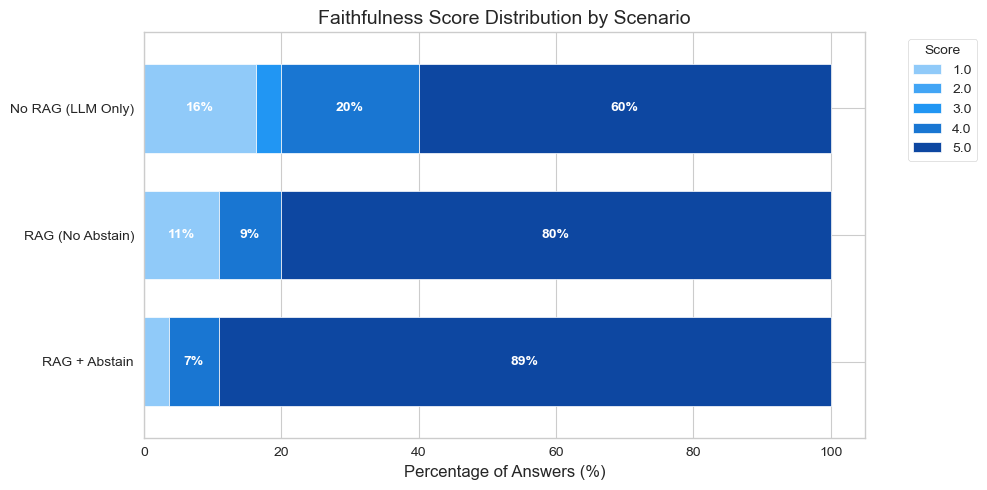

Plot saved to: ../output\relevance_distribution_stacked.png


<Figure size 1000x600 with 0 Axes>

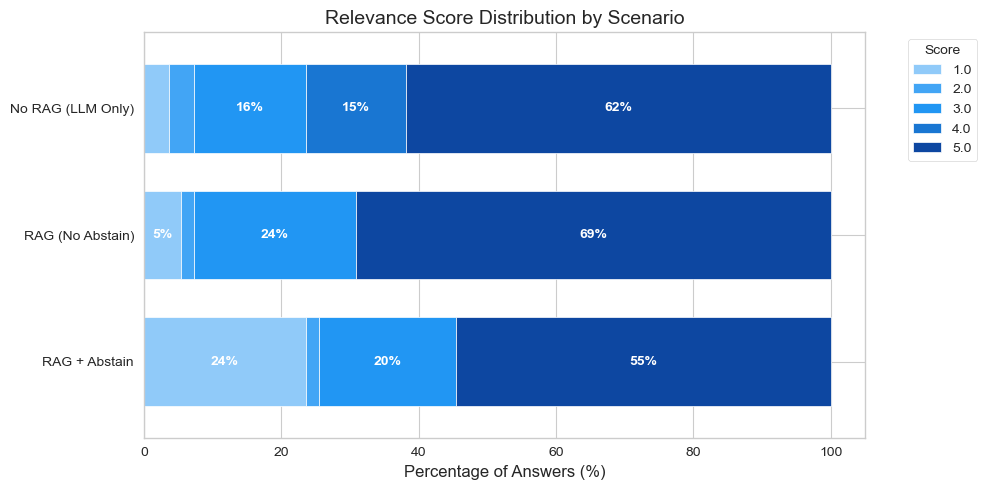


Generating Gap Distribution Plot...
Plot saved to: ../output\faithfulness_gap_histogram.png


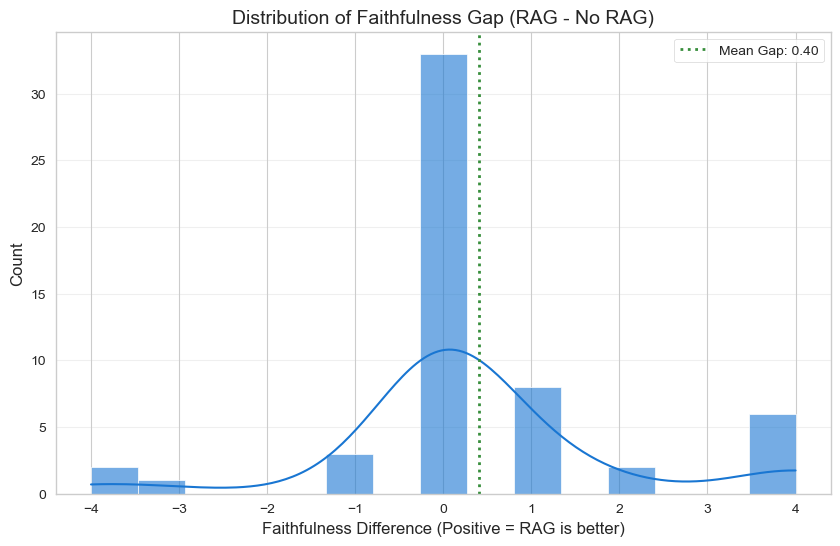


Generating Faithfulness Score Plot...
Plot saved to: ../output\faithfulness_mean_score.png


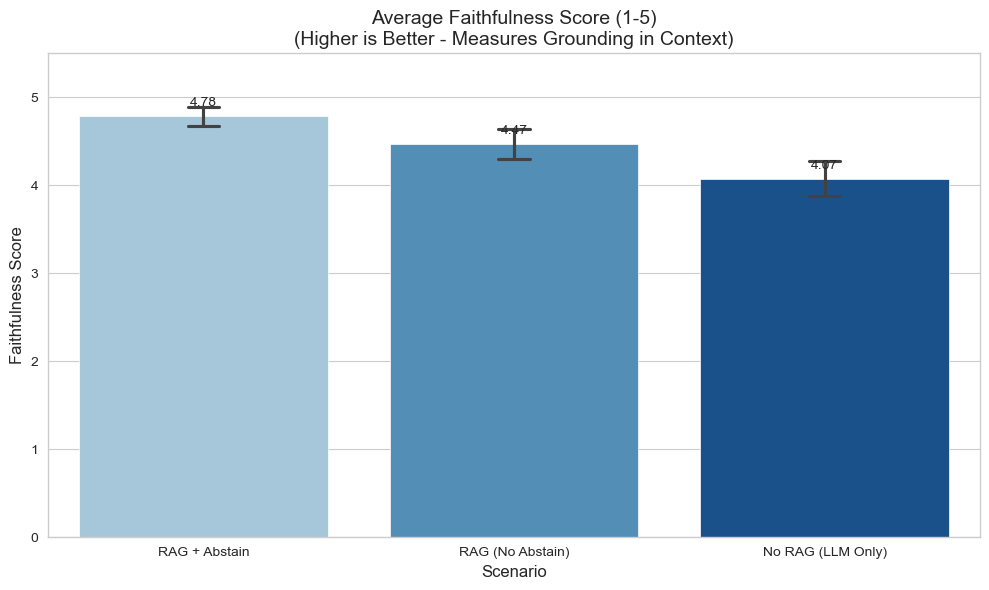


Generating Comparative Gains Plot...
Plot saved to: ../output\comparative_gains.png


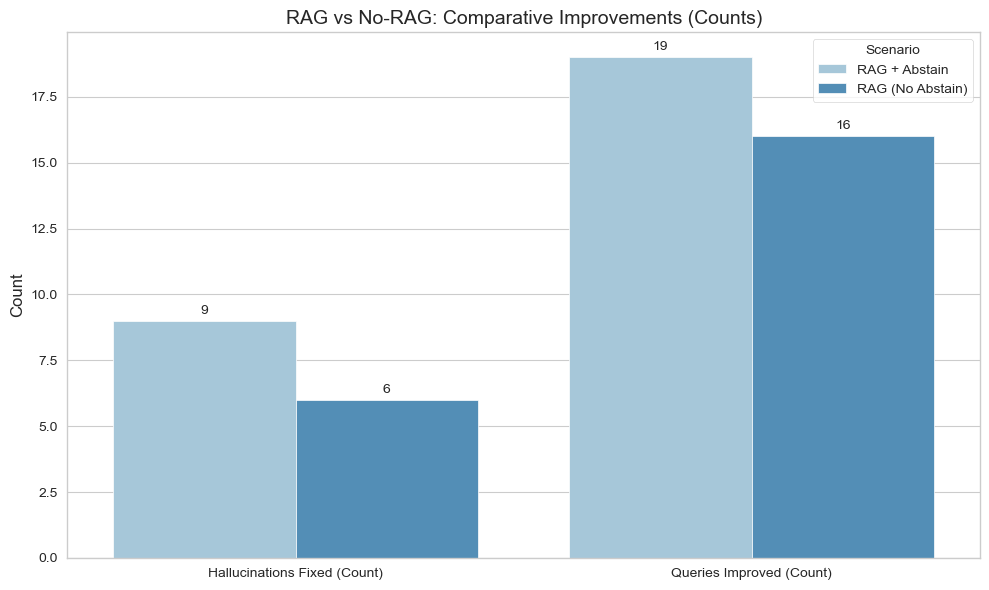


=== Statistical Significance Tests (Wilcoxon Signed-Rank) ===
Comparing Median Faithfulness between scenarios (Paired Data)

RAG + Abstain vs No RAG (LLM Only):
   n=55, Statistic=42.5, p-value=0.0031 **
   Median Diff: 0.00
RAG (No Abstain) vs No RAG (LLM Only):
   n=55, Statistic=69.0, p-value=0.0567 (ns)
   Median Diff: 0.00
RAG + Abstain vs RAG (No Abstain):
   n=55, Statistic=0.0, p-value=0.0339 *
   Median Diff: 0.00

--- Abstention Statistics ---
            Scenario  Abstained  Total Queries  Abstention Rate
0  No RAG (LLM Only)          0             54         0.000000
1   RAG (No Abstain)          0             54         0.000000
2      RAG + Abstain         12             54        22.222222

--- Score Statistics (All Answers) ---
                  Faithfulness                        Relevance         \
                          mean median       std count      mean median   
Scenario                                                                 
No RAG (LLM Only)     4

In [ ]:
# ==========================================
# 6. Visualizations
# ==========================================
plot_df = results_df.copy() 

# Stacked Bar Charts
print("\nGenerating Stacked Bar Charts...")
src.visualization.plot_score_distribution_stacked(plot_df, metric="Faithfulness", save_path='../output')
src.visualization.plot_score_distribution_stacked(plot_df, metric="Relevance", save_path='../output')

# Gap Analysis
print("\nGenerating Gap Distribution Plot...")
src.visualization.plot_faithfulness_gap_distribution(results_df, save_path='../output')

# Mean Scores
src.visualization.plot_faithfulness_scores(plot_df, save_path='../output')

# Comparative Gains
src.visualization.plot_comparative_gains(plot_df, save_path='../output')

# Statistical Tests
src.evaluation.run_statistical_tests(plot_df, metric_name="Faithfulness")

In [ ]:
# ==========================================
# 7. Statistical Summary
# ==========================================
total_queries = len(eval_queries) if 'eval_queries' in locals() else 50

stats_summary = src.evaluation.calculate_evaluation_stats(results_df, total_queries)

print("\n--- Abstention Statistics ---")
print(stats_summary['abstain_stats'])

print("\n--- Score Statistics (All Answers) ---")
print(stats_summary['score_stats'])

print("\n=== Safety Analysis: Hallucination Rates & Reliability ===")
print("Defining 'Hallucination' as Faithfulness Score <= 2.0")
print(stats_summary['risk_stats'].to_string(index=False))

# Save stats
with open('../output/evaluation_summary.txt', 'w') as f:
    f.write("--- Abstention Statistics ---\n")
    f.write(stats_summary['abstain_stats'].to_string())
    f.write("\n\n--- Score Statistics (All Answers) ---\n")
    f.write(stats_summary['score_stats'].to_string())
    f.write("\n\n--- Safety Analysis ---\n")
    f.write(stats_summary['risk_stats'].to_string(index=False))

# Section 4: Qualitative Analysis ("Smoking Guns")

We identify specific cases where RAG provided a faithful answer while the No-RAG model hallucinated.
These "Smoking Gun" examples demonstrate the safety value of the pipeline.

In [ ]:
# ==========================================
# 8. Smoking Gun Analysis
# ==========================================
# Define output file
smoking_gun_output_path = '../output/smoking_gun_report.txt'

# Run analysis
src.evaluation.analyze_smoking_guns(
    results_df, 
    rag=rag if 'rag' in locals() else None, 
    context_map=context_map,
    output_file=smoking_gun_output_path
)

Loading results from CSV...
Columns in loaded CSV: ['Scenario', 'Query', 'Answer', 'Abstained', 'Faithfulness', 'Faithfulness_Reasoning', 'Relevance', 'Relevance_Reasoning', 'Meta_Faithfulness_Passed', 'Meta_Relevance_Passed']
Faithfulness_Reasoning column found.

=== SMOKING GUN ANALYSIS ===
Total Comparisons: 55
Smoking Guns Found: 6 (Cases where RAG was correct and No-RAG hallucinated)
Significant Improvements: 2 (Cases where RAG was correct and No-RAG was vague/partial)

>>> CATEGORY 1: SEVERE HALLUCINATIONS (RAG Correct vs No-RAG Wrong) <<<

SMOKING GUN 1:
QUESTION: What is the primary mechanism of risk for S. maltophilia infection in hospitalized individuals?

[Original Context Snippet]:
Stenotrophomonas maltophilia (S. maltophilia) infection is a healthcare-associated bacterial infection caused by S. maltophilia bacteria. These bacteria typically colonize (live in or on) areas of the body without causing infection. However, people who are hospitalized and receiving treatment for

In [ ]:
# ==========================================
# 9. Generate Detailed Report
# ==========================================
output_file = '../output/detailed_evaluation_summary.txt'

src.evaluation.generate_detailed_summary_report(
    results_df, 
    output_file, 
    context_map=context_map
)

print(f"Detailed report generated at: {output_file}")

Generating summary analysis report to: ../output/detailed_evaluation_summary.txt
Report generated successfully.


# Section 5: Final Report

Based on the comprehensive evaluation of 50+ queries, we can draw the following conclusions about the RAG pipeline's performance and safety.

### Safety & Hallucination Prevention
We manually verified specific high-impact examples against the raw ground truth dataset (`data/medDataset_processed.csv`) to confirm the safety benefits of the RAG pipeline.

1.  **Benign Familial Neonatal Seizures (BFNS)**
    *   **RAG**: Correctly identified "generalized tonic-clonic seizures".
    *   **No-RAG**: Hallucinated "Infantile spasms".
    *   **Why this matters**: This is a critical medical error. BFNS is a **benign** condition starting in the first days of life. "Infantile spasms" (West Syndrome) is a **severe** epileptic encephalopathy with poor prognosis that typically starts later (4-8 months). Confusing the two could lead to unnecessary alarm and incorrect treatment pathways.

2.  **Neuroferritinopathy**
    *   **RAG**: Correctly identified "release of excess iron" (ferritin light chain mutation).
    *   **No-RAG**: Hallucinated "ferroportin deficiency" (confusing it with Ferroportin Disease).
    *   **Why this matters**: Neuroferritinopathy is a neurodegenerative disorder (brain iron accumulation). "Ferroportin deficiency" causes Ferroportin Disease, a systemic iron overload condition (haemochromatosis) primarily affecting the liver. Confusing these distinct genetic mechanisms leads to a fundamental misunderstanding of the disease's pathology.

3.  **Stenotrophomonas maltophilia**
    *   **RAG**: Correctly identified "impaired immune systems" as the risk factor.
    *   **No-RAG**: Incorrectly focused on "antibiotic resistance" as a risk factor for *acquisition*.
    *   **Why this matters**: While *S. maltophilia* is drug-resistant, resistance makes it hard to *treat*, not necessarily more likely to be *acquired*. The critical clinical insight is that it is an opportunistic pathogen attacking immunocompromised hosts. Missing this distinction fails to identify the vulnerable patient population (e.g., cystic fibrosis, ICU patients).

### Robust Abstention
The pipeline correctly handles out-of-domain queries, a critical feature for a medical AI.
*   **Query**: "How do I bake a chocolate cake?"
*   **RAG + Abstain**: Correctly responded "I don't know" (Confidence: 1.67 > Threshold). **Faithfulness Score: 5.0**.
*   **No-RAG**: Happily provided a recipe. **Faithfulness Score: 1.0** (Hallucination relative to the medical context).

### Limitations
While the RAG system is superior, the **Evaluation Pipeline** itself has limitations that must be addressed in future work.

**The "Verbosity Bias" Problem in LLM-as-a-Judge**
The Gemma 2 9B judge is generally strict but can be fooled by highly plausible-sounding hallucinations.
*   **Example**: *Renal dysplasia-limb defects syndrome*.
*   **Issue**: The No-RAG model invented a list of generic symptoms ("renal hypoplasia", "muscle weakness") that sounded correct but were **not** in the specific HPO list provided in the context.
*   **Judge Error**: The judge assigned a **Score of 5.0**, incorrectly stating that these symptoms were present in the context.
*   **Lesson**: Smaller models (like 9B) struggle to verify negative constraints ("is this specific term present?") when faced with semantically related but technically incorrect terms.

### Potential Improvements
1.  **Upgrade the Judge**: Deploy a larger reasoning model (e.g., GPT-4o, Claude 3.5 Sonnet) for the evaluation phase to eliminate false positives like the *Renal Dysplasia* case.
2.  **Refine Retrieval**: Investigate cases where RAG answers were incomplete to ensure the retrieval step captures all relevant paragraph chunks.
3.  **User Interface**: Move from notebook-based interaction to a Streamlit/Gradio web interface for real-time demonstration.